# Alzheimer Classifier

In this notebook, We will build a classifier to predict whether a patient has Alzheimer's disease or not. I will use a dataset that contains MRI images of the brain. The implementation is based on this [paper](https://www.researchgate.net/publication/349874169_A_CNN_based_framework_for_classification_of_Alzheimer's_disease).

# Introduction

Alzheimer's disease (AD) is a neurodegenerative disorder that causes memory loss and cognitive decline. It is the most common cause of dementia, accounting for 60-70% of cases. The exact cause of AD is unknown, but it is believed to be a combination of genetic, environmental, and lifestyle factors. There is currently no cure for AD, but early detection and treatment can help slow the progression of the disease. So the need for an accurate and reliable method for diagnosing AD is crucial.

In [43]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tqdm
import os
import sys
from PIL import Image
import cv2
from collections import Counter, defaultdict
import pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import data as tfdata
from tensorflow import image as tfimage
from tensorflow import io as tfio

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization, ReLU, Conv2D, MaxPooling2D, Lambda
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical, plot_model, img_to_array, normalize
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import GlorotUniform, GlorotNormal, HeNormal, HeUniform
from keras.regularizers import l2

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score, accuracy_score

## Dataset

The dataset used in this notebook is the [ADNI](https://www.kaggle.com/datasets/subhranilsarkar/alzheimer-s-disease-neuroimaging-adni-dataset) dataset from Kaggle. The dataset contains MRI images of the brain from patients with Alzheimer's disease and healthy controls. The dataset is divided into two classes: Mild Cognitive Impairment (MCI), and Alzheimer's disease (AD). The dataset contains a total of 1654 images, with 965 images from AD patients and 689 images from MCIs. For pre-processing, since most of the things are already done, we just need to resize the images to a fixed size.

In [44]:
try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    AD_PATH = "/content/drive/My Drive/University/NN/HW2/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD"
    MCI_PATH = "/content/drive/My Drive/University/NN/HW2/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI"
else:
    AD_PATH = "../data/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD"
    MCI_PATH = "../data/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI"


In [45]:
class ImageDataset:
    def __init__(self, AD_path: str, MCI_path: str, img_size: tuple[int, int] = (256, 256), batch_size: int = 2, **kwargs):
        self.AD_path = AD_path
        self.MCI_path = MCI_path
        self.img_size = img_size
        self.batch_size = batch_size
        self._zero_one_hot = tf.one_hot(0, depth=2)
        self._one_one_hot = tf.one_hot(1, depth=2)
        self._load()


    def _load_image(self, path: str) -> tf.Tensor:
        img = tfio.read_file(path)
        img = tfio.decode_jpeg(img, channels=3)
        img = tfimage.resize(img, self.img_size)

        # img = tf.py_function(self._apply_dynamic_thresholding, [img], Tout=tf.uint8)
        # uncomment the above line to apply dynamic thresholding

        img = tf.cast(img, tf.float32) / 255.0
        return img

    def _apply_dynamic_thresholding(self, img: tf.Tensor) -> tf.Tensor:
        img_np = img_to_array(img)
        img_np = (img_np * 255).astype(np.uint8)
        img_np = cv2.adaptiveThreshold(img_np, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        return tf.convert_to_tensor(img_np)

    def _load(self):
        MCI_files = tfio.gfile.glob(os.path.join(self.MCI_path, "*.jpg"))
        AD_files = tfio.gfile.glob(os.path.join(self.AD_path, "*.jpg"))

        MCI_data = tfdata.Dataset.from_tensor_slices(MCI_files)
        AD_data = tfdata.Dataset.from_tensor_slices(AD_files)

        MCI_data = MCI_data.map(self._load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        AD_data = AD_data.map(self._load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        MCI_label = tf.data.Dataset.from_tensor_slices([self._zero_one_hot] * len(MCI_files))
        AD_label = tf.data.Dataset.from_tensor_slices([self._one_one_hot] * len(AD_files))

        MCI_data = tf.data.Dataset.zip((MCI_data, MCI_label))
        AD_data = tf.data.Dataset.zip((AD_data, AD_label))

        self.MCI_data = MCI_data
        self.AD_data = AD_data



    def augment_image(self, img: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.1, 0.2)
        img = tf.image.random_hue(img, 0.1)
        img = tf.image.random_saturation(img, 0.1, 0.2)
        img = tf.image.random_crop(img, size=[*self.img_size, 3])
        # img = img[tf.newaxis, ...] # uncomment this line to add a batch dimension
        return img, label

    def augment_dataset(self, num_samples: int = 4):
        MCI_data = self.MCI_data
        AD_data = self.AD_data

        for _ in range(num_samples):
            MCI_data = MCI_data.concatenate(self.MCI_data.map(self.augment_image))
            AD_data = AD_data.concatenate(self.AD_data.map(self.augment_image))

        self.MCI_data = MCI_data
        self.AD_data = AD_data

        self.concat_data = tf.data.Dataset.concatenate(MCI_data, AD_data)



    def get_batch(self) -> tuple[tf.data.Dataset, tf.data.Dataset]:
        AD_data = self.AD_data.shuffle(1000).batch(self.batch_size)
        MCI_data = self.MCI_data.shuffle(1000).batch(self.batch_size)
        return AD_data, MCI_data

    def get_data(self) -> tuple[tf.data.Dataset, tf.data.Dataset]:
        return self.AD_data, self.MCI_data

    def get_sample_data(self, num_samples: int = 1) -> tuple[tf.Tensor, tf.Tensor]:
        AD_samples = [next(iter(self.AD_data.shuffle(buffer_size=100))) for _ in range(num_samples)]
        MCI_samples = [next(iter(self.MCI_data.shuffle(buffer_size=100))) for _ in range(num_samples)]
        return AD_samples, MCI_samples

    def _split_data(self, data: tf.data.Dataset, split_size: float = .05) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
        dataset_size = len(data)
        test_size = int(split_size * dataset_size)
        val_size = int((1 - split_size) * dataset_size * .1)
        train_size = dataset_size - test_size

        data = data.shuffle(dataset_size)

        test_data = data.take(test_size)
        data = data.skip(test_size)

        val_data = data.take(val_size)
        data = data.skip(val_size)

        train_data = data.take(train_size)
        data = data.skip(train_size)

        return train_data, val_data, test_data

    def split_train_test_validation(self, split_size: float = .1):
        ADI_train, ADI_val, ADI_test = self._split_data(self.AD_data, split_size)
        MCI_train, MCI_val, MCI_test = self._split_data(self.MCI_data, split_size)

        self.train = tf.data.Dataset.concatenate(ADI_train, MCI_train)
        self.val = tf.data.Dataset.concatenate(ADI_val, MCI_val)
        self.test = tf.data.Dataset.concatenate(ADI_test, MCI_test)


    def show_sample(self, num_samples: int = 1):
        AD_samples, MCI_samples = self.get_sample_data(num_samples)

        figs, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
        if num_samples == 1:
            axes = axes[np.newaxis, :]
        for i in range(num_samples):
            axes[i, 0].imshow(AD_samples[i][0])
            axes[i, 0].set_title("AD")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(MCI_samples[i][0])
            axes[i, 1].set_title("MCI")
            axes[i, 1].axis("off")

        plt.show()

    def plot_distribution(self):
        plt.figure(figsize=(10, 5))

        sns.countplot(x="label", data=pd.DataFrame({"label": [0] * len(self.MCI_data) + [1] * len(self.AD_data)}))
        plt.title("Distribution of AD and MCI")
        plt.xticks(ticks=[0, 1], labels=["MCI", "AD"])

        plt.show()

    def plot_distribution_split(self):
        print(f"Train size     : {len(self.train)}")
        print(f"Validation size: {len(self.val)}")
        print(f"Test size      : {len(self.test)}")

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        train_decoded_labels = [label.numpy() for _, label in self.train]
        train_decoded_labels = [np.argmax(label) for label in train_decoded_labels]
        sns.countplot(x="label", data=pd.DataFrame({"label": train_decoded_labels }))
        plt.title("Train Distribution")
        plt.xticks(ticks=[0, 1], labels=["MCI", "AD"])

        plt.subplot(1, 3, 2)
        val_decoded_labels = [label.numpy() for _, label in self.val]
        val_decoded_labels = [np.argmax(label) for label in val_decoded_labels]
        sns.countplot(x="label", data=pd.DataFrame({"label": val_decoded_labels }))
        plt.title("Validation Distribution")
        plt.xticks(ticks=[0, 1], labels=["MCI", "AD"])

        plt.subplot(1, 3, 3)
        test_decoded_labels = [label.numpy() for _, label in self.test]
        test_decoded_labels = [np.argmax(label) for label in test_decoded_labels]
        sns.countplot(x="label", data=pd.DataFrame({"label": test_decoded_labels }))
        plt.title("Test Distribution")
        plt.xticks(ticks=[0, 1], labels=["MCI", "AD"])

        plt.show()

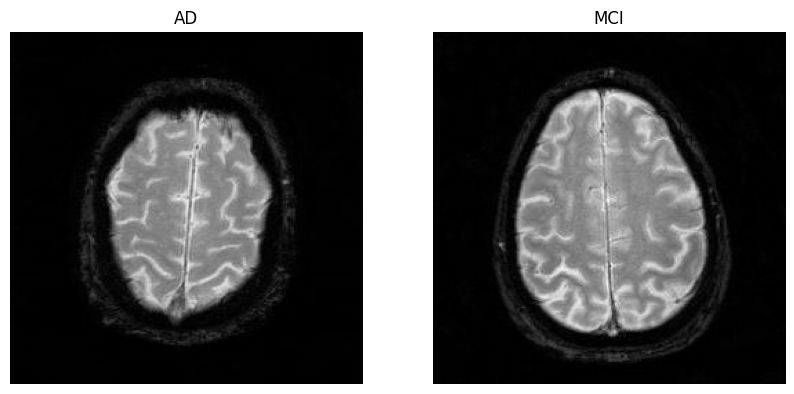

In [46]:
dataset = ImageDataset(AD_PATH, MCI_PATH)
dataset.show_sample()

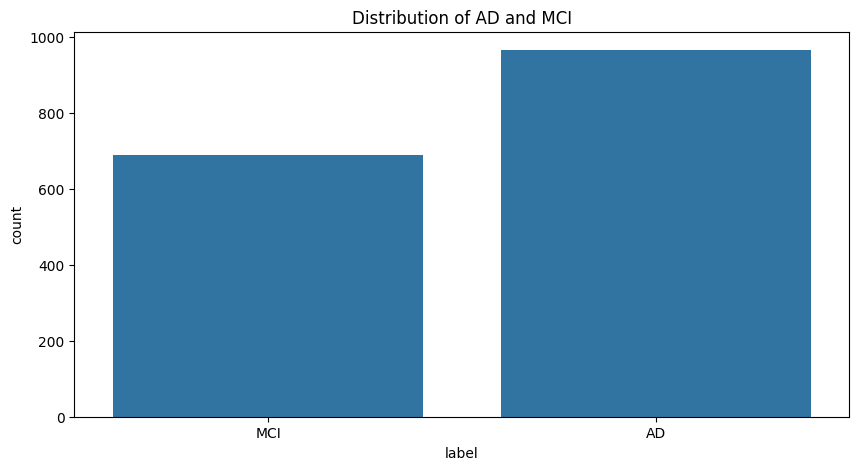

In [47]:
dataset.plot_distribution()

## Data Augmentation

Data augmentation is a technique used to artificially increase the size of the training dataset by applying random transformations to the images. This helps to improve the generalization of the model and reduce overfitting. We will apply random rotations, flips, shifts, and zooms to the images.

In [48]:
dataset.augment_dataset()

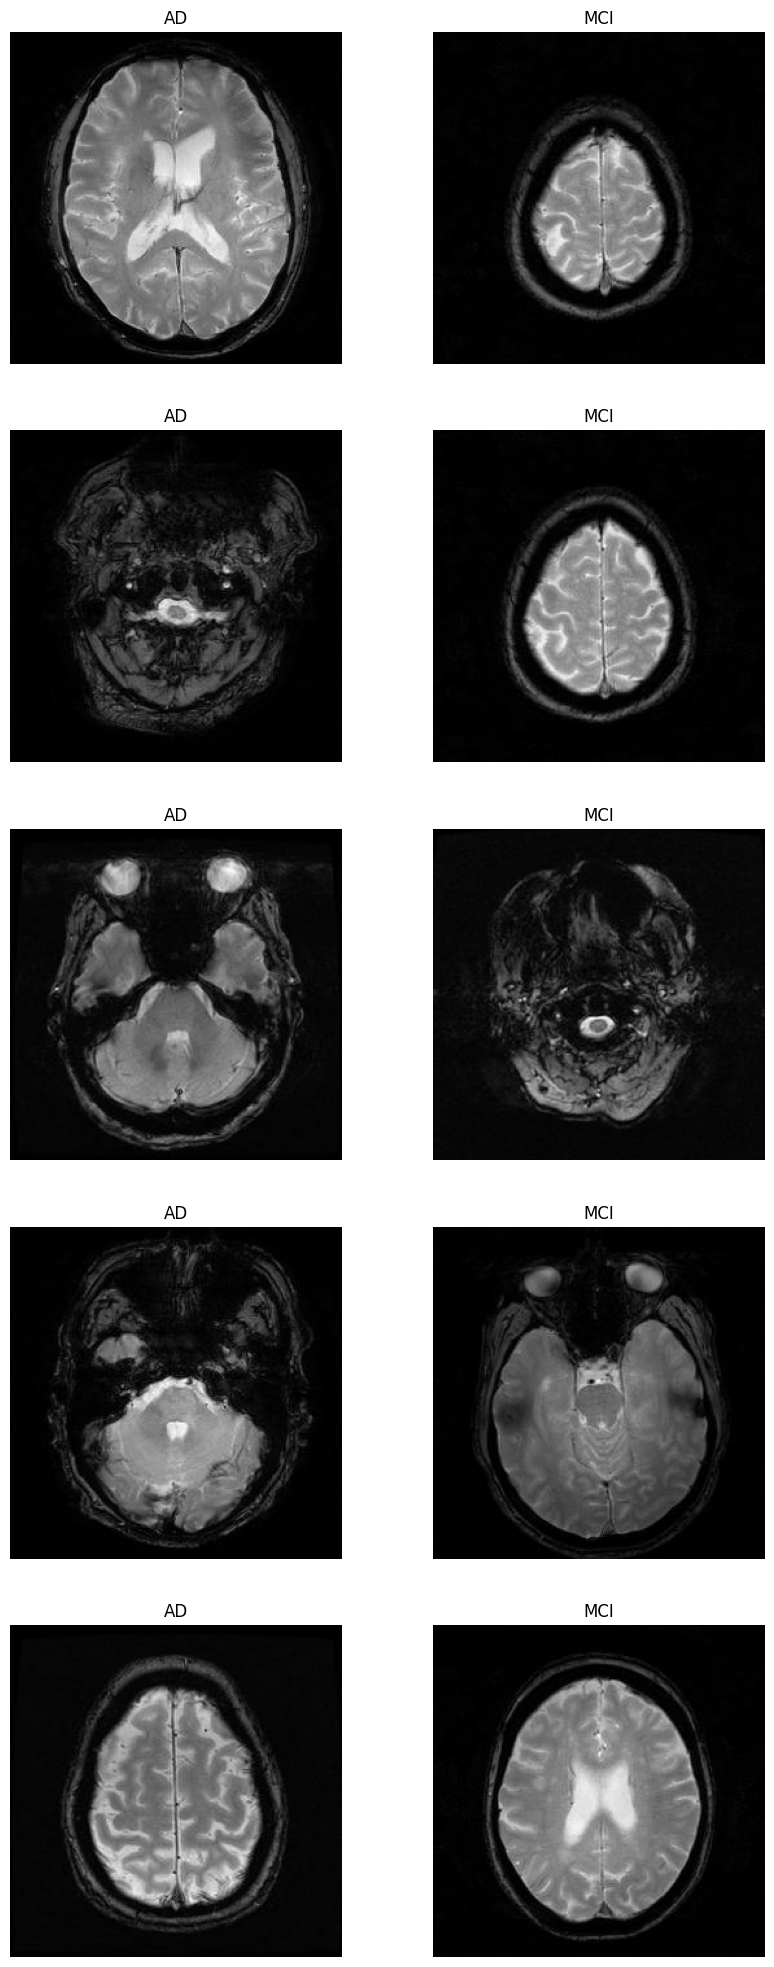

In [49]:
dataset.show_sample(5)

## Train and Test Split

We will split the dataset into training and testing sets. We will use 95% of the data for training and 5% for testing. From the training set, we will further split 10% of the data for validation.

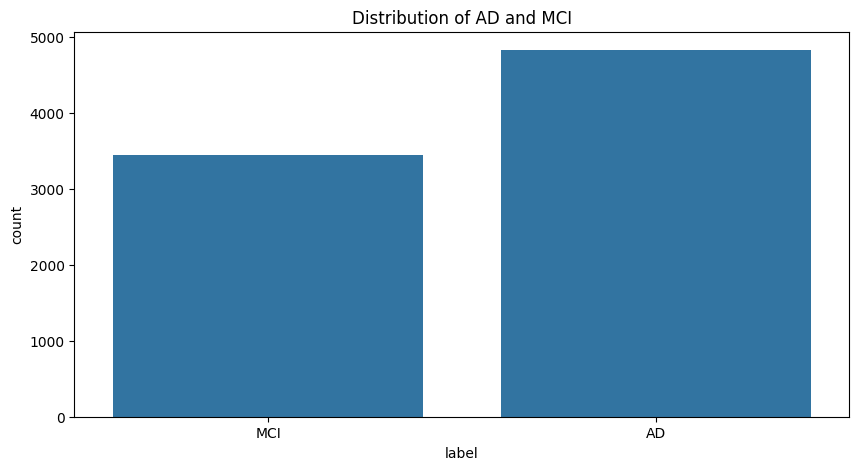

In [50]:
dataset.plot_distribution()

In [51]:
print(dataset.concat_data.element_spec)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))


In [52]:
dataset.split_train_test_validation()

Train size     : 6700
Validation size: 744
Test size      : 826


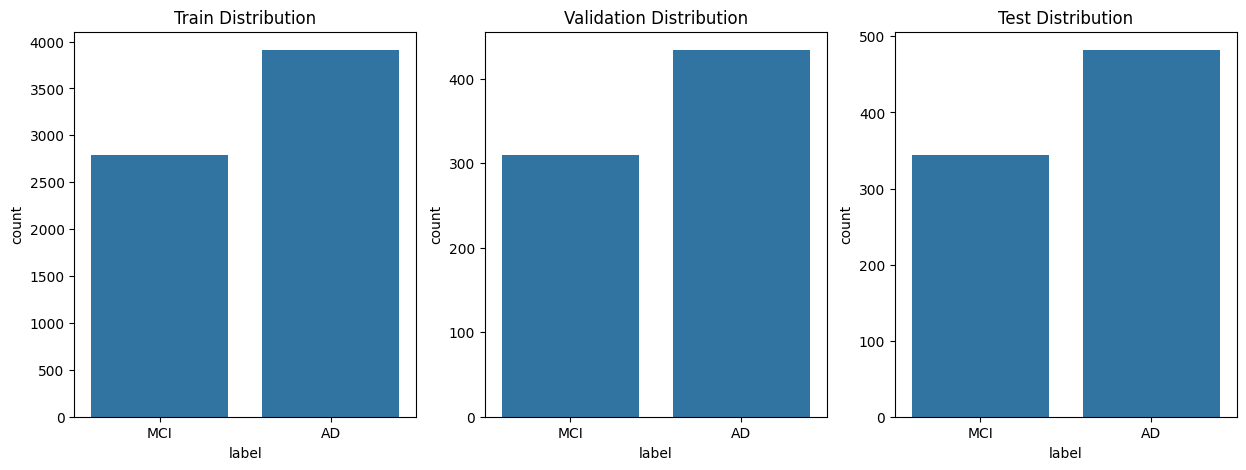

In [53]:
dataset.plot_distribution_split()

## Implementation

### Gloroit Initialization

The Glorot initialization, also known as Xavier initialization, is a method used to initialize the weights of a neural network. It is based on the idea that the weights should be initialized in such a way that the variance of the input and output of each layer is the same. This helps to prevent the gradients from becoming too large or too small during training. For a fully connected layer with input size `n_in` and output size `n_out`, the weights `W` are initialized according to a uniform distribution in the range:

$$
W \sim U\left[-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}}\right]
$$

Here, `U[a, b]` denotes a uniform distribution in the range `[a, b]`. This initialization helps to avoid vanishing or exploding gradients at the start of the training process.


### Activation Function

We will use the ReLU activation function in the hidden layers of the network. The ReLU function is a non-linear activation function that introduces non-linearity into the network and helps to learn complex patterns in the data. tanh and sigmoid activation functions are also used in the network. For output layer we will use softmax activation function.

Formulas for each of the activation functions are as follows:

$$ReLU(x) = max(0, x)$$

$$tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

$$sigmoid(x) = \frac{1}{1 + e^{-x}}$$

$$softmax(x) = \frac{e^{x_{i}}}{\sum_{j} e^{x_{j}}}$$

### Loss Function

We will use the categorical cross-entropy loss function to train the model. The categorical cross-entropy loss function is used for multi-class classification problems and measures the difference between the predicted probability distribution and the true probability distribution of the classes. The formula for the categorical cross-entropy loss function is as follows:

$$L(y, \hat{y}) = -\frac{1}{N} \sum_{i = 1}^{N} \sum_{j = 1}^{C} (y_{i} = j) log(\hat{y}_{i})$$

Where $y$ is the true probability distribution, $\hat{y}$ is the predicted probability distribution, and $N$ is the number of classes.

Using Cross-Entropy loss function after the softmax layer speeds the convergence of the neural network due to the gradient vanishing problem.


Another possible loss function is the negative log-likelihood loss function. The negative log-likelihood loss function is used for multi-class classification problems and measures the difference between the predicted probability distribution and the true probability distribution of the classes. The formula for the negative log-likelihood loss function is as follows:

$$L(y, \hat{y}) = -\frac{1}{N} \sum_{i} log(\hat{y}_{i})$$

Where $y$ is the true probability distribution, $\hat{y}$ is the predicted probability distribution, and $N$ is the number of classes.

The reason we chose the categorical cross-entropy loss function is that it is more stable and faster to converge than the negative log-likelihood loss function.

### Optimizer

We will use the Adam optimizer to train the model. The Adam optimizer is an adaptive learning rate optimization algorithm that combines the advantages of two other popular optimization algorithms: AdaGrad and RMSProp. The Adam optimizer adapts the learning rate for each parameter based on the first and second moments of the gradients. This helps to speed up the convergence of the model and improve its performance.

### Regularization

We will use L2 regularization to prevent overfitting in the model. L2 regularization adds a penalty term to the loss function that penalizes large weights. This helps to prevent the model from fitting the noise in the training data and improves its generalization performance. The L2 regularization term is given by:

$$L2 = \lambda \sum_{i} w_{i}^{2}$$

Where $\lambda$ is the regularization strength and $w_{i}$ are the weights of the model.

### Dropout

We will use dropout regularization to prevent overfitting in the model. Dropout is a technique that randomly sets a fraction of the input units to zero during training. This helps to prevent the model from relying too much on any single input unit and improves its generalization performance. We will apply dropout to the hidden layers of the network.

### Batch Normalization

We will use batch normalization to improve the training of the model. Batch normalization is a technique that normalizes the input to each layer of the network to have zero mean and unit variance. This helps to stabilize the training process and speed up convergence. We will apply batch normalization to the hidden layers of the network.

### Model Architecture

The model architecture consists of a series of convolutional layers followed by max-pooling layers. The convolutional layers extract features from the input images, while the max-pooling layers downsample the feature maps to reduce the spatial dimensions. The output of the convolutional layers is flattened and passed through a series of fully connected layers to make the final prediction. The model uses ReLU activation functions in the hidden layers and softmax activation function in the output layer. The model is trained using the categorical cross-entropy loss function and the Adam optimizer.

The model architecture is as follows:

1.  Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
2.  Batch Normalization
3.  ReLU Activation
4.  Dropout (0.5)
5.  Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
6.  Batch Normalization
7.  ReLU Activation
8.  Max Pooling (pool size 2x2, stride 2x2)
9.  Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
10. Batch Normalization
11. ReLU Activation
12. Dropout (0.5)
13. Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
14. Batch Normalization
15. ReLU Activation
16. Max Pooling (pool size 2x2, stride 2x2)
17. Flatten
18. Fully Connected Layer (128 units)
19. Batch Normalization
20. ReLU Activation
21. Dropout (0.5)
22. Fully Connected Layer (64 units)
23. Batch Normalization
24. ReLU Activation
25. Dropout (0.5)
26. Fully Connected Layer (2 units)
27. Softmax Activation
28. Output Layer
29. Categorical Cross-Entropy Loss Function
30. Adam Optimizer

In [54]:
class BatchLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        self.seen = 0

    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        self.accs.append(logs.get("accuracy"))

    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get("val_loss"))
        self.val_accs.append(logs.get("val_accuracy"))

In [55]:
class CNN:
    def __init__(
        self,
        input_shape: tuple[int, int, int] = (256, 256, 3),
        num_classes: int = 2,
        model: keras.Model = None,
        name: str = None,
        path: str = None,
        **kwargs,
    ):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model() if model is None else model
        self.name = name if name is not None else "propose_model"
        self.path = path if path is not None else f"../models/{self.name}.keras"

    def _build_model(self):
        initilaizer = GlorotUniform(seed=42)
        regularizer = l2(0.01)
        model = Sequential(
            [
                Input(shape=self.input_shape),
                Conv2D(
                    32,
                    (3, 3),
                    strides=(1, 1),
                    padding="same",
                    kernel_initializer=initilaizer,
                    kernel_regularizer=regularizer,
                ),
                BatchNormalization(),
                ReLU(),
                Dropout(0.5),
                Conv2D(
                    32,
                    (3, 3),
                    strides=(1, 1),
                    padding="same",
                    kernel_initializer=initilaizer,
                    kernel_regularizer=regularizer,
                ),
                BatchNormalization(),
                ReLU(),
                MaxPooling2D((2, 2)),
                Conv2D(
                    32,
                    (3, 3),
                    strides=(1, 1),
                    padding="same",
                    kernel_initializer=initilaizer,
                    kernel_regularizer=regularizer,
                ),
                BatchNormalization(),
                ReLU(),
                Dropout(0.5),
                Conv2D(
                    32,
                    (3, 3),
                    strides=(1, 1),
                    padding="same",
                    kernel_initializer=initilaizer,
                    kernel_regularizer=regularizer,
                ),
                BatchNormalization(),
                ReLU(),
                MaxPooling2D((2, 2)),
                Flatten(),
                Dense(
                    128,
                    activation="relu",
                    kernel_initializer=initilaizer,
                    kernel_regularizer=regularizer,
                ),
                BatchNormalization(),
                ReLU(),
                Dropout(0.5),
                Dense(
                    64,
                    activation="relu",
                    kernel_initializer=initilaizer,
                    kernel_regularizer=regularizer,
                ),
                BatchNormalization(),
                ReLU(),
                Dropout(0.5),
                Dense(
                    2,
                    activation="softmax",
                    kernel_initializer=initilaizer,
                    kernel_regularizer=regularizer,
                ),
            ]
        )

        model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=["accuracy"])
        return model

    def train(self, train_data: tf.data.Dataset, val_data: tf.data.Dataset, epochs: int = 5):
        early_stopping = EarlyStopping(monitor="val_loss", patience=2)
        batch_logger = BatchLogger()

        self.history = self.model.fit(
            train_data.batch(2).prefetch(tf.data.experimental.AUTOTUNE),
            validation_data=val_data.batch(2).prefetch(tf.data.experimental.AUTOTUNE),
            epochs=epochs,
            callbacks=[early_stopping, batch_logger],
            verbose=1,
        )
        self.batch_logger = batch_logger

        with open(f"../logs/{self.name}_history.pkl", "wb") as f:
            pickle.dump(self.history.history, f)

        self.save()

    def evaluate(self, test_data: tf.data.Dataset):
        return self.model.evaluate(test_data)

    def predict(self, data: tf.data.Dataset):
        return self.model.predict(data)

    def plot_model(self, path: str):
        # add code to depict model architecture
        pass

    def plot_history(self, history: dict = None):
        if history is None:
            history = self.history.history

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history["loss"], label="Loss")
        plt.plot(history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.title("Loss")

        plt.subplot(1, 2, 2)
        plt.plot(history["accuracy"], label="Accuracy")
        plt.plot(history["val_accuracy"], label="Validation Accuracy")
        plt.legend()
        plt.title("Accuracy")

        plt.show()
        
    def plot_detailed_history(self, batch_logger: BatchLogger = None):
        if batch_logger is None:
            batch_logger = self.batch_logger
            
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(batch_logger.losses, label="Loss")
        plt.plot(np.linspace(0, len(batch_logger.losses), len(batch_logger.val_losses), endpoint=False), 
                batch_logger.val_losses, label="Validation Loss")
        plt.legend()
        plt.title("Loss")

        plt.subplot(1, 2, 2)
        plt.plot(batch_logger.accs, label="Accuracy")
        plt.plot(
            np.linspace(0, len(batch_logger.accs), len(batch_logger.val_accs), endpoint=False), 
            batch_logger.val_accs, 
            label="Validation Accuracy"
        )
        plt.legend()
        plt.title("Accuracy")

        plt.show()


    def plot_roc_curve(self, y_true: np.ndarray, y_pred: np.ndarray):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 5))
        plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

    def analyze(self, test_data: tf.data.Dataset):
        y_true = []
        y_pred = []
        for img, label in test_data.batch(1).prefetch(tf.data.experimental.AUTOTUNE):
            y_true.extend([np.argmax(label.numpy()[0])])
            y_pred.extend(np.argmax(self.model.predict(img, verbose=0), axis=1))

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        print("*" * 50)
        print(f"Accuracy : {accuracy_score(y_true, y_pred)}")
        print(f"Precision: {precision_score(y_true, y_pred)}")
        print(f"Recall   : {recall_score(y_true, y_pred)}")
        print(f"F1 Score : {f1_score(y_true, y_pred)}")
        print("*" * 50)

        print(classification_report(y_true, y_pred))
        print()

        print(confusion_matrix(y_true, y_pred))
        print()

        roc_auc_score(y_true, y_pred)
        print()

    def save(self, path: str = None):
        if path is None:
            path = self.path
        self.model.save(path)

    def load(self, path: str = None):
        if path is None:
            path = self.path
        self.model = load_model(path)

## Analysis

We will train the model on the training set and evaluate its performance on the testing set. We will calculate the accuracy, precision, recall, and F1 score of the model. We will also plot the confusion matrix to visualize the performance of the model. ROC curve and AUC score will also be calculated to evaluate the performance of the model.

The formulas for accuracy, precision, recall, and F1 score are as follows:

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

$$Precision = \frac{TP}{TP + FP}$$

$$Recall = \frac{TP}{TP + FN}$$

$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

Where $TP$ is the number of true positives, $TN$ is the number of true negatives, $FP$ is the number of false positives, and $FN$ is the number of false negatives.

ROC curve is a graphical representation of the true positive rate (sensitivity) versus the false positive rate (1-specificity) for a binary classification problem. The AUC score is the area under the ROC curve and provides a measure of the model's performance.

AUC score ranges from 0 to 1, where 0 indicates a poor model and 1 indicates a perfect model.

In [56]:
proposed_model = CNN()
proposed_model.load("../models/propose_model.keras")

In [57]:
proposed_model.train(dataset.train, dataset.val)

Epoch 1/5
3350/3350 [==============================] - 85s 24ms/step - loss: 1.1933 - accuracy: 0.9825 - val_loss: 3.8364 - val_accuracy: 0.4167
Epoch 2/5
3350/3350 [==============================] - 80s 23ms/step - loss: 0.8235 - accuracy: 0.9828 - val_loss: 4.2032 - val_accuracy: 0.4167
Epoch 3/5
3350/3350 [==============================] - 87s 25ms/step - loss: 0.9453 - accuracy: 0.9831 - val_loss: 3.6095 - val_accuracy: 0.4167
Epoch 4/5
3350/3350 [==============================] - 84s 23ms/step - loss: 1.3457 - accuracy: 0.9825 - val_loss: 6.1556 - val_accuracy: 0.4167
Epoch 5/5
3350/3350 [==============================] - 87s 24ms/step - loss: 0.4989 - accuracy: 0.9836 - val_loss: 3.6353 - val_accuracy: 0.4167


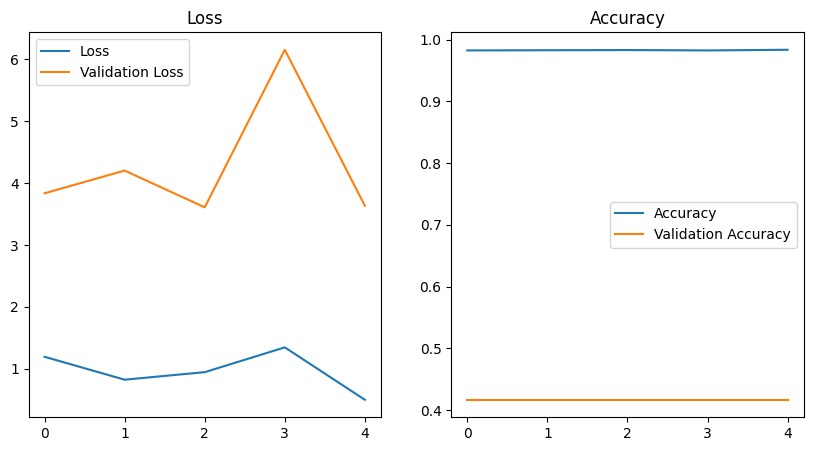

In [58]:
proposed_model.plot_history()

In [59]:
proposed_model.analyze(dataset.test)

Accuracy: 0.41646489104116224
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Classification Report
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       344
           1       0.00      0.00      0.00       482

    accuracy                           0.42       826
   macro avg       0.21      0.50      0.29       826
weighted avg       0.17      0.42      0.24       826

Confusion Matrix
[[344   0]
 [482   0]]
ROC AUC Score


c:\Users\attar\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\attar\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\attar\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\attar\minico